<a href="https://colab.research.google.com/github/artms-18/tensorflow_fundamentals/blob/main/Intro_to_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to NLP Fundamentals in Tensorflow

NLP has the goal of deriving information out of natural language (could be sequences text or speech).

Another common term for NLP problems is sequence to sequence problems (seq2seq)

## Check for GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-26c2f90c-ef96-e31e-280b-a32c0be33415)


## Get helper functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import a series of helper function for the notebook

from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2021-05-21 12:11:17--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-05-21 12:11:18 (96.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get a text dataaset

The dataset we're going to be using is Kaggle's introduction to NLP dataset

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

unzip_data("nlp_getting_started.zip")

--2021-05-21 12:11:20--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.33.208, 172.217.7.240, 172.217.8.16, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.33.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.004s  

2021-05-21 12:11:20 (146 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Visualizing a text dataset

To visualie our text samples, we first have to read them in, one way to do so would be to use Python: 

Another way to do this is to use pandas.

(If text dataset is very large, cannot ise pandas (will tkaes of to much RAM).



In [4]:
import pandas as pd

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv('test.csv')

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train_df['text'][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [6]:
# Shuffle training dataframe

train_df_shuffled = train_df.sample(frac = 1, random_state = 42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [7]:
# What does the test dataframe look like?

test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
# How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [9]:
# How many total samples?
len(train_df), len(test_df)

(7613, 3263)

In [10]:
# Let's visualize some random training examples

import random

random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than the total number of samples

for row in train_df_shuffled[['text', 'target']][random_index: random_index + 5].itertuples():
  _, text, target = row #gets rid of index
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 0 (not real disaster
Text:
HELLFIRE EP - SILENTMIND &amp; @_bookofdaniel  https://t.co/FKqJY3EzyG

---

Target: 1 (real disaster)
Text:
Rainstorm Update: Further North or Further South? http://t.co/50vdQ7A1M5 http://t.co/QH6oXfT9Ir

---

Target: 0 (not real disaster
Text:
#BakeOffFriends #GBBO 'The one with the mudslide and the guy with the hat'

---

Target: 0 (not real disaster
Text:
Spent too many hours sinking into the wonderfully created worlds of Mafia and Mafia II in my life. Excited for another installment.

---

Target: 0 (not real disaster
Text:
ng2x5 mhtw4fnet

Watch Michael Jordan absolutely destroy this meme-baiting camper - FOXSportscom

---



### Split data into training and validation sets

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
# Use train_test_split top split training data into training and validation sets

train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled['text'].to_numpy(), train_df_shuffled['target'].to_numpy(),
                                                                            test_size = 0.1, random_state = 42)

In [13]:
# Check the lengths

len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [14]:
# Check the first 10 samples

train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

## Converting text into numbers

When dealing with a text problem, one of the first things you'll have to do before you can build a midek is to convert your text to numbers.

There are a few ways to do this, namely:
* Tokenization - direct mapping of  token( a toke could be a word or a character) to number
* embedding - create a matrix of feature vectors for each token the size of the feature vector can be defined and this embedding can be learned

### Text vectorization (tokenization)

In [15]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [16]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Use the default TextVectorization parameters

text_vectorizer = TextVectorization(max_tokens = None, # how many words in the vocab (automatically add <OOV>)
                                    standardize = "lower_and_strip_punctuation",
                                    split = "whitespace", 
                                    ngrams = None,
                                    output_mode = "int", #how to map tokens to numbers
                                    output_sequence_length = None, #pads each sequence to the logest sequence
                                    pad_to_max_tokens = True)

In [17]:
# Find the average number of tokens (words) in the training tweets

round(sum(len(i.split()) for i in train_sentences)) / len(train_sentences)

14.901036345059115

In [18]:
# Setup text vectorization variables

max_vocab_length = 10000 #max num of words to have in our vocabulary
max_length = 15 # max length our seuqences will be (how many words in a tweet, amodel would see)

text_vectorizer = TextVectorization(max_tokens = max_vocab_length, output_mode= 'int', output_sequence_length = max_length)

In [19]:
#fit the text vectorier to the training text

text_vectorizer.adapt(train_sentences)

In [20]:
# Create a sample sentence and tokenize it

sample_sentence = "Theres a flood in my street!"

text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [21]:
# Choose a random sentence from the training dataset and tokenize iot

random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
 @Drake is body bagging meek meanwhile he's on tour with Nicki all hush hush...he's put 2 diss tracks out and meek 0 but dude started it lol

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[1028,    9,   83,  490,  770,    1,  277,   11, 1942,   14, 2840,
          44,    1,    1,  370]])>

In [22]:
# Get the unique words in the vocabulary

words_in_vocab = text_vectorizer.get_vocabulary() #get all of the unique words in the training data
top_5_words = words_in_vocab[:5] # get the most common words
bottom_5_words = words_in_vocab[-5:] #get the least common words
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"5 most comon words: {top_5_words}")

Number of words in vocab: 10000
5 most comon words: ['', '[UNK]', 'the', 'a', 'in']


### Creating an Embedding using an Embedding Layer

To make our embedding, we're going to use tensoflows embedding layer

The parameters we actually care about:
* `input_dim` = the size of our vocabulary
* `output_dim` = the size of the output embedding vector, for example, a value of 100 would mean each token gets represented by a vecotr 100 long
* `input_length` = length of the sequences being passed to the embedding layer

In [23]:
from tensorflow.keras import layers

# in keras, wordks best when numbers are divisible by eight

embedding = layers.Embedding(input_dim = max_vocab_length,
                             output_dim = 128,
                             input_length = max_length
                             )
embedding

In [24]:
# Get a random sentence from the training set

random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\n\nEmbedded version:")

# Embed the random sentence (turn into dense vecotrs of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
 @ssssnell yeah I agree but it's the shock factor that ropes people in if they just show devastation then it angers me

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-1.1920929e-06, -2.2328163e-02, -4.7984291e-02, ...,
          3.3129763e-02,  4.0442143e-02,  1.2490429e-02],
        [-4.3988228e-03,  5.0778985e-03,  3.1221304e-02, ...,
         -3.6465358e-02,  3.7527569e-03, -1.0781467e-02],
        [-3.7880160e-02,  4.4931363e-02, -1.0431297e-03, ...,
          3.6116693e-02, -1.5258778e-02,  4.1501526e-02],
        ...,
        [ 3.0082706e-02, -2.0393943e-02,  1.6927902e-02, ...,
         -4.8526812e-02, -2.0499099e-02, -2.7555004e-03],
        [ 2.0229045e-02,  4.5082334e-02,  1.0795247e-02, ...,
          2.7901802e-02, -2.6081456e-02, -4.6860792e-02],
        [ 5.0734505e-03,  3.0449998e-02,  4.9739528e-02, ...,
          4.9521279e-02,  4.7418680e-02,  1.7350268e-02]]], dtype=float32)>

In [25]:
# Chekc out a single token's embedding

sample_embed[0][0], sample_embed[0][0].shape, random_sentence[0]

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-1.19209290e-06, -2.23281626e-02, -4.79842909e-02,  8.51105899e-04,
         1.13688596e-02, -4.77164164e-02, -1.83068737e-02, -2.06819903e-02,
         2.55493559e-02, -2.56594904e-02, -7.20440224e-03,  4.98137362e-02,
         1.46337040e-02, -3.92037854e-02,  1.35732628e-02,  4.29277495e-03,
         2.83725746e-02,  4.06878032e-02,  1.50275715e-02, -6.01126999e-03,
        -1.92109346e-02, -3.64801884e-02, -3.67699862e-02, -4.24828194e-02,
        -1.75637119e-02, -4.21383604e-02, -2.27323063e-02,  2.55069472e-02,
         4.65599559e-02,  3.86852883e-02,  4.65694182e-02,  3.02269347e-02,
         2.22348310e-02, -3.95994261e-03,  1.71688907e-02, -4.60550785e-02,
        -2.05768831e-02, -4.18415181e-02,  9.66705009e-03, -1.50634535e-02,
        -1.61875002e-02,  3.71287130e-02,  1.70701407e-02,  3.24261189e-03,
        -3.55769768e-02,  1.32207163e-02, -1.43217668e-02,  4.67100479e-02,
        -2.94195488e-03, -4.56331633e-0

## Modelling a text dataset (running a series of experiments)

Now we're got a wat to turn our text srequences into numbers, it's time to start building a series of modelling experiments, start from a baseline and move on from there 

* Model 0: Naive Bayes (baseline)
* Model 1: Feed-forward neual network (dense model)
* Model 2: GRU model (RNN)
* Model 4: Bidirectional-LSTM
* Model 5: 1d Convolutional Neural Network (CNN)
* Model 6: Tensorflow Hub Pretrained Geature Extractor (using transfer learning for NLP)
* Model 7: Same as model 6 with 10% of training data

How are we going to approach all of these?

Use the standard steps in modelling with tensorflow:

* Create a model
* Build a model
* Compile a model
* Fit the model

### Model 0: Getting a baseline

As with all machine learning modelling experiments it's important to create a baseline model so u got a benchmark for future experiments to build upon

To create our baseline, we'll use SKlearns Multinomial Naive Bayes using the TF-IDF formula to convert our words to numbers

> **Note:** It's common practive to use non-DL algorithms as a baseline because of their speed, then later using DL to improve

In [26]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline

model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()),
                    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data

model_0.fit(train_sentences, train_labels)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [27]:
# Evaluate our baseline model 

baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [28]:
# Make predictions

baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating an evaluation function for our model experiments

We could evaluate model's predictin with different methods every time, but this could be cumbersome and could easily be fixed with a function

Let's create one to compare our model's predictions with the truth labels using the following metrics:

* Accuracy
* Precision
* Recall
* F1-score

In [29]:
# Function to evaluate: accuracty, precision, recall, f1-score

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calulates model accuracy, precision, recall and f1 score of a binary classification model.
  """
  #Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  #Calculate model precision, recall ,and f01 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average = 'weighted')
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1": model_f1}
  return model_results

In [30]:
baseline_results = calculate_results(y_true = val_labels, y_pred = baseline_preds)

baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 1: A simple dense model

In [31]:
# Create a tensorboard callback (need to create a new one for each model)

from helper_functions import create_tensorboard_callback

# Create a directory to save TensorBoard logs

SAVE_DIR = "model_logs"

In [32]:
from tensorflow.keras import layers

inputs = layers.Input(shape = (1,), dtype = tf.string) # inputs are 1-dimensional
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numberized imputs
x = layers.GlobalAveragePooling1D()(x) # condense the feature vector for each token to one vector
#x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation = "sigmoid")(x) # Create the output layer, want binary output so use sigmoid

model_1 = tf.keras.Model(inputs, outputs, name = "model_1_dense")

In [33]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [34]:
# Compile mode

model_1.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(), metrics = ["accuracy"])

In [35]:
# Fit the mode
model_1_history = model_1.fit(x = train_sentences, y = train_labels, epochs = 15, validation_data = (val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(dir_name = SAVE_DIR, experiment_name = "model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20210521-121127
Epoch 1/15
215/215 [==============================] - 7s 19ms/step - loss: 0.6535 - accuracy: 0.6504 - val_loss: 0.5350 - val_accuracy: 0.7533
Epoch 2/15
215/215 [==============================] - 3s 15ms/step - loss: 0.4617 - accuracy: 0.8108 - val_loss: 0.4675 - val_accuracy: 0.7900
Epoch 3/15
215/215 [==============================] - 3s 15ms/step - loss: 0.3459 - accuracy: 0.8643 - val_loss: 0.4545 - val_accuracy: 0.7953
Epoch 4/15
215/215 [==============================] - 3s 15ms/step - loss: 0.2897 - accuracy: 0.8924 - val_loss: 0.4604 - val_accuracy: 0.7900
Epoch 5/15
215/215 [==============================] - 3s 15ms/step - loss: 0.2375 - accuracy: 0.9179 - val_loss: 0.4799 - val_accuracy: 0.7874
Epoch 6/15
215/215 [==============================] - 3s 15ms/step - loss: 0.1945 - accuracy: 0.9331 - val_loss: 0.5022 - val_accuracy: 0.7822
Epoch 7/15
215/215 [==============================] - 3s 15ms/step -

In [36]:
# Check the results

model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.7749 - accuracy: 0.7677


[0.7749280333518982, 0.7677165269851685]

In [37]:
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

(762, 1)

In [38]:
# look at a single prediction

model_1_pred_probs[0] # anything below 0.5 = disaster, abouve = non-=disaster

array([0.4626977], dtype=float32)

In [39]:
# look at the first 10 predictions

model_1_pred_probs[:10]

array([[0.4626977 ],
       [0.6682182 ],
       [0.9987765 ],
       [0.05306555],
       [0.00102521],
       [0.98595756],
       [0.81940114],
       [0.9999695 ],
       [0.9999378 ],
       [0.6452061 ]], dtype=float32)

In [40]:
# Convert model prediction probablilities to label format

model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))

model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [41]:
# calculate our model_1 results

model_1_results = calculate_results(y_true = val_labels, y_pred = model_1_preds)

model_1_results

{'accuracy': 76.77165354330708,
 'f1': 0.7663871505080737,
 'precision': 0.7679905783589133,
 'recall': 0.7677165354330708}

In [42]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [43]:
import numpy as np

np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

# Visualizing learned embeddings


In [44]:
# get the vocab from the text vecotrization layer

words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [45]:
# Model 1 summary

model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [46]:
# Get the wieght matrix of embedding layer
# (these are the numerical representations of each token in our training data, which have been learned for 5 epocks)

embed_weights = model_1.get_layer("embedding").get_weights()[0]

print(embed_weights.shape) # same size as vocab size and embedding dim (output dim of our embedding layer)

(10000, 128)


In [47]:
embed_weights

array([[-0.03180891, -0.01780707,  0.01819176, ..., -0.0300837 ,
        -0.00759256,  0.0219715 ],
       [ 0.0302438 , -0.03809477, -0.02303667, ...,  0.0070496 ,
         0.0071551 ,  0.02109558],
       [ 0.04067535,  0.00242341,  0.0199963 , ...,  0.03887146,
         0.01928949, -0.01903889],
       ...,
       [ 0.02447901, -0.03519092, -0.01848989, ..., -0.01275156,
        -0.00849829,  0.00465221],
       [-0.05818878,  0.00430097, -0.03793936, ...,  0.05681108,
         0.0644078 , -0.02518207],
       [-0.14171779, -0.160965  , -0.17992261, ...,  0.1301797 ,
         0.17196128, -0.11405523]], dtype=float32)

In [48]:
# Create embedding files

import io

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

#for index, word in enumerate(words_in_vocab):
  #if index == 0:
   # continue  # skip 0, it's padding.
  #vec = embed_weights[index]
  #out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  #out_m.write(word + "\n")
#out_v.close()
#out_m.close()

In [49]:
# Download files from Colab to upload to projector

#try:
  #from google.colab import files
  #files.download('vectors.tsv')
  #files.download('metadata.tsv')
#except Exception:
  #pass

## Recurrent Neural Networks (RNN's)

RNN's are usefull for sequence data.

The premise of a recurrent neural network is to use the representation of a previous input to aid the respresentation of a later input.

### Model 2: LSTM

LSTM = ling short term memory (one of the most popular LSTM cells)

Our structure of an RNN typically looks like this:

'''
Input (text) -> Tokenize -> EMbedding -> Layers (RNN's/dense) -> Output (label probability)
'''

In [50]:
# Create an LSTM model

from tensorflow.keras import layers

inputs = layers.Input(shape = (1,), dtype = "string")
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
#x = layers.LSTM(64, return_sequences = True)(x)
print(x.shape)
x = layers.LSTM(64)(x) # when you're stacking RNN cells together, you need to return_sequences = true
print(x.shape)
#x = layers.Dense(64, activation = 'relu')(x)
outputs = layers.Dense(1, activation = "sigmoid")(x)

model_2 = tf.keras.Model(inputs, outputs, name = "model_2_LSTM")

(None, 15, 128)
(None, 15, 128)
(None, 64)


In [51]:
# Compile the model

model_2.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(), metrics = ["accuracy"])

In [52]:
model_2_history = model_2.fit(train_sentences, train_labels, epochs = 5, 
                              validation_data = (val_sentences, val_labels), callbacks = [create_tensorboard_callback(SAVE_DIR, "model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20210521-121220
Epoch 1/5
215/215 [==============================] - 35s 23ms/step - loss: 0.2175 - accuracy: 0.9334 - val_loss: 0.7953 - val_accuracy: 0.7664
Epoch 2/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0635 - accuracy: 0.9773 - val_loss: 0.8366 - val_accuracy: 0.7559
Epoch 3/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0630 - accuracy: 0.9764 - val_loss: 1.0193 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0563 - accuracy: 0.9755 - val_loss: 1.2554 - val_accuracy: 0.7703
Epoch 5/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0461 - accuracy: 0.9809 - val_loss: 1.2096 - val_accuracy: 0.7677


In [53]:
# Make predictions with LSTM model

model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]


array([[2.3086476e-01],
       [5.6343716e-01],
       [9.9940169e-01],
       [9.1937810e-02],
       [2.4748145e-04],
       [9.9910188e-01],
       [3.9664701e-01],
       [9.9991679e-01],
       [9.9990213e-01],
       [9.9877769e-01]], dtype=float32)

In [54]:
# Convert model 2 pred probs to labels

model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 0., 1., 1., 1.], dtype=float32)>

In [55]:
model_2_results = calculate_results(y_true = val_labels, y_pred = model_2_preds)
model_2_results

{'accuracy': 76.77165354330708,
 'f1': 0.7661635916954678,
 'precision': 0.7683074753719822,
 'recall': 0.7677165354330708}

### Model 3: GRU

Another poppular and effective RNN component is the GRU or gated recurrent unit.

The GRU cell has similar features to an LSTM cell but has less parameters.

In [56]:
# Build an RNN using the GRU cell
from tensorflow.keras import layers
inputs = layers.Input(shape = (1,), dtype = tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x)
#x = layers.LSTM(64, return_sequences = True)(x)
#print(x.shape)
#x = layers.GRU(64)(x) # make sure return seuqences DOES NO equal true OR add a global average pooling layer instead
#x = layers.Dense(64, activation = "relu")(x)
outputs = layers.Dense(1, activation = "sigmoid")(x)


model_3 = tf.keras.Model(inputs, outputs)

In [57]:
 model_3.summary(
     
 )

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
gru (GRU)                    (None, 64)                37248     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_________________________________________________________________


In [58]:
# COmpile the model

model_3.compile(loss = "binary_crossentropy", optimizer= tf.keras.optimizers.Adam(), metrics = ["accuracy"])


In [59]:
# Fit

model_3_history = model_3.fit(train_sentences,
                              train_labels, epochs = 10,
                              validation_data = (val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(SAVE_DIR, "model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20210521-121311
Epoch 1/10
215/215 [==============================] - 7s 23ms/step - loss: 0.2601 - accuracy: 0.8782 - val_loss: 0.8981 - val_accuracy: 0.7703
Epoch 2/10
215/215 [==============================] - 4s 18ms/step - loss: 0.0499 - accuracy: 0.9812 - val_loss: 0.9794 - val_accuracy: 0.7651
Epoch 3/10
215/215 [==============================] - 4s 18ms/step - loss: 0.0489 - accuracy: 0.9826 - val_loss: 0.9722 - val_accuracy: 0.7625
Epoch 4/10
215/215 [==============================] - 4s 18ms/step - loss: 0.0497 - accuracy: 0.9791 - val_loss: 1.0026 - val_accuracy: 0.7507
Epoch 5/10
215/215 [==============================] - 4s 18ms/step - loss: 0.0417 - accuracy: 0.9817 - val_loss: 1.0705 - val_accuracy: 0.7612
Epoch 6/10
215/215 [==============================] - 4s 18ms/step - loss: 0.0384 - accuracy: 0.9837 - val_loss: 1.3343 - val_accuracy: 0.7612
Epoch 7/10
215/215 [==============================] - 4s 17ms/step - l

In [60]:
# Make some predictions with GRu model

model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

array([[2.8312037e-02],
       [6.5348315e-01],
       [9.9983060e-01],
       [1.1892082e-01],
       [7.4013326e-05],
       [9.9989295e-01],
       [9.5670360e-01],
       [9.9998212e-01],
       [9.9995542e-01],
       [9.9950850e-01]], dtype=float32)

In [61]:
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [62]:
# Calculate model 3 results

model_3_results = calculate_results(y_true = val_labels, y_pred = model_3_preds)
model_3_results

{'accuracy': 75.59055118110236,
 'f1': 0.7548850741589771,
 'precision': 0.7556483058194802,
 'recall': 0.7559055118110236}

### Model 4: Bidirectional RNN

ormal RNN's go from left to right (just like you'd read an English sentence) however, a bidiractional RNN goes from right to left as well as left to right.

In [63]:
# Build a dirirectional RNN in Tensorflow

from tensorflow.keras import layers

inputs = layers.Input(shape = (1,), dtype = "string")
x = text_vectorizer(inputs)
x = embedding(x)
#x = layers.Bidirectional(layers.LSTM(64, return_sequences = True))(x)
#print(x.shape)
x = layers.Bidirectional(layers.GRU(64))(x)
print(x.shape)
outputs = layers.Dense(1, activation = 'sigmoid')(x)
model_4 = tf.keras.Model(inputs, outputs, name = "model_4_bidirectional")

(None, 128)


In [64]:
# Get a summary

model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               74496     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 1,354,625
Trainable params: 1,354,625
Non-trainable params: 0
_________________________________________________________________


In [65]:
# Compile model

model_4.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy'])

In [66]:
model_4_history = model_4.fit(train_sentences, train_labels, epochs = 5, validation_data = (val_sentences, val_labels), callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                                                                                                                                 "model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20210521-121354
Epoch 1/5
215/215 [==============================] - 8s 26ms/step - loss: 0.2014 - accuracy: 0.9304 - val_loss: 1.0507 - val_accuracy: 0.7585
Epoch 2/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0449 - accuracy: 0.9802 - val_loss: 1.2351 - val_accuracy: 0.7546
Epoch 3/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0311 - accuracy: 0.9875 - val_loss: 1.2661 - val_accuracy: 0.7533
Epoch 4/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0443 - accuracy: 0.9841 - val_loss: 1.1487 - val_accuracy: 0.7493
Epoch 5/5
215/215 [==============================] - 4s 19ms/step - loss: 0.0329 - accuracy: 0.9831 - val_loss: 1.3983 - val_accuracy: 0.7572


In [67]:
# Make predictions with out bidiractional ,odel
 
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

array([[4.0013706e-03],
       [7.0484376e-01],
       [9.9969268e-01],
       [2.0382249e-01],
       [1.0115288e-05],
       [9.9974412e-01],
       [9.7342569e-01],
       [9.9996996e-01],
       [9.9988770e-01],
       [9.9734253e-01]], dtype=float32)

In [68]:
# Convert

model_4_pred = tf.squeeze(tf.round(model_4_pred_probs))
model_4_pred[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [69]:
# Calculate the results of our bidiractional model

model_4_results = calculate_results(y_true = val_labels, y_pred = model_4_pred )
model_4_results

{'accuracy': 75.7217847769029,
 'f1': 0.7555947144839635,
 'precision': 0.7576149234046069,
 'recall': 0.7572178477690289}

### Model 5: Conv1D 

We've used CNNs for images but images are typically 2D (hegith x width)...however, our text data is 1d.

The typical structure of a Conv1D model for sequen ces (in our case, text):

```
Inputs(test -> Tokenization -> Embedding -> Cpmv1D -> Pool -> Outputs (class probs)
```

In [70]:
from tensorflow.keras import layers

input = layers.Input(shape = (1,), dtype = "string")
x = text_vectorizer(input)
x = embedding(x)
x = layers.Conv1D(32, 6, activation = 'relu')(x) #kernal size is reffered to as n-gram side (strides rn is 1, but can change to hop) #padding = 'valid' (some words mised) output is smaller 'same' = smae size
x = layers.GlobalMaxPooling1D()(x)
output = layers.Dense(1, activation = "sigmoid")(x)

model_5 = tf.keras.Model(input, output, name = "model_5_conv")


In [71]:
model_5.summary()

Model: "model_5_conv"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
conv1d (Conv1D)              (None, 10, 32)            24608     
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,304,641
Trainable params: 1,304,641
Non-trainable params: 0
____________________________________________

In [72]:
# Compiling the model

model_5.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy'])



In [73]:
# Fitting the model

model_5_history = model_5.fit(train_sentences, train_labels, epochs = 10, 
                              validation_data = (val_sentences, val_labels), callbacks = [create_tensorboard_callback(SAVE_DIR, "model_5_conv")])

Saving TensorBoard log files to: model_logs/model_5_conv/20210521-121420
Epoch 1/10
215/215 [==============================] - 6s 21ms/step - loss: 0.1638 - accuracy: 0.9519 - val_loss: 1.0179 - val_accuracy: 0.7559
Epoch 2/10
215/215 [==============================] - 4s 17ms/step - loss: 0.0578 - accuracy: 0.9775 - val_loss: 1.1725 - val_accuracy: 0.7533
Epoch 3/10
215/215 [==============================] - 4s 16ms/step - loss: 0.0515 - accuracy: 0.9786 - val_loss: 1.2620 - val_accuracy: 0.7598
Epoch 4/10
215/215 [==============================] - 3s 16ms/step - loss: 0.0408 - accuracy: 0.9828 - val_loss: 1.3136 - val_accuracy: 0.7533
Epoch 5/10
215/215 [==============================] - 4s 17ms/step - loss: 0.0396 - accuracy: 0.9838 - val_loss: 1.3578 - val_accuracy: 0.7507
Epoch 6/10
215/215 [==============================] - 3s 16ms/step - loss: 0.0406 - accuracy: 0.9842 - val_loss: 1.3309 - val_accuracy: 0.7520
Epoch 7/10
215/215 [==============================] - 4s 16ms/step - 

In [74]:
from tensorflow.keras import layers
inputs = layers.Input(shape = (1,), dtype = tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters = 64, kernel_size = 5, activation = "relu")(x)
x = layers.GlobalMaxPool1D()(x)
#x = layers.Dense(64, activation = "relu")(x)
outputs = layers.Dense(1, activation = "sigmoid")(x)
model_6 = tf.keras.Model(inputs, outputs, name = "model_6_Conv1D")

model_6.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy'])

model_6.summary()

Model: "model_6_Conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 11, 64)            41024     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 1,321,089
Trainable params: 1,321,089
Non-trainable params: 0
__________________________________________

In [75]:
# Fit the model

model_6_history = model_6.fit(train_sentences, train_labels, epochs = 5,
                              validation_data = (val_sentences, val_labels), callbacks = [create_tensorboard_callback(SAVE_DIR, "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20210521-121459
Epoch 1/5
215/215 [==============================] - 5s 19ms/step - loss: 0.1268 - accuracy: 0.9645 - val_loss: 1.2019 - val_accuracy: 0.7480
Epoch 2/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0388 - accuracy: 0.9855 - val_loss: 1.4420 - val_accuracy: 0.7493
Epoch 3/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0433 - accuracy: 0.9797 - val_loss: 1.4235 - val_accuracy: 0.7454
Epoch 4/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0365 - accuracy: 0.9829 - val_loss: 1.3967 - val_accuracy: 0.7402
Epoch 5/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0370 - accuracy: 0.9814 - val_loss: 1.4031 - val_accuracy: 0.7388


In [76]:
# Make some prediction with our Conv1D model

model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred = tf.squeeze(tf.round(model_6_pred_probs))
model_6_pred[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [77]:
model_6_results = calculate_results(y_true = val_labels, y_pred = model_6_pred)
model_6_results

{'accuracy': 73.88451443569554,
 'f1': 0.7381096174702226,
 'precision': 0.7383009731517823,
 'recall': 0.7388451443569554}

## Model6: Tensorflow Hub Pretrained Sentence Encoder

Using transfer learning for NLP

In [78]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence, "When you call the use on a sentence, it utrns it into numbers"])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01157027  0.02485911  0.02878048 -0.012715    0.03971538  0.08827761
  0.02680985  0.05589839 -0.01068729 -0.00597292  0.00639323 -0.0181952
  0.00030814  0.09105889  0.05874645 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865346 -0.04209306  0.02678981  0.03011008  0.00321069
 -0.00337971 -0.04787357  0.02266719 -0.00985925 -0.04063613 -0.01292093
 -0.04666385  0.056303   -0.03949255  0.00517688  0.02495828 -0.07014441
  0.02871509  0.04947684 -0.00633978 -0.08960193  0.02807117 -0.00808362
 -0.01360601  0.0599865  -0.10361787 -0.05195374  0.00232955 -0.0233253
 -0.03758106  0.0332773 ], shape=(50,), dtype=float32)


In [79]:
# transforms THE WHOLE sentence into a 512 dimensional vector

In [80]:
# Create Keras Layer using the USE pretrained layer from tensorflow hub

sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape = [],
                                        dtype = tf.string,
                                        trainable = False,
                                        name = "USE")

In [81]:
# Create model using the sequenctial API

model_7 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation = "relu"),
    layers.Dense(1, activation = 'sigmoid', name = 'output_layer')
], name = "model_7_USE")

# Compile

model_7.compile(loss = 'binary_crossentropy', optimizer = 
                tf.keras.optimizers.Adam(), metrics = ['accuracy'])

model_7.summary()

Model: "model_7_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_6 (Dense)              (None, 64)                32832     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [82]:
# Train a classifier on top of USE pretrained embeddings

model_7_history = model_7.fit(train_sentences, train_labels, epochs = 15,
                              validation_data = (val_sentences, val_labels), callbacks = [create_tensorboard_callback(SAVE_DIR, "model_7_use")])

Saving TensorBoard log files to: model_logs/model_7_use/20210521-121540
Epoch 1/15
215/215 [==============================] - 8s 24ms/step - loss: 0.5879 - accuracy: 0.7411 - val_loss: 0.4546 - val_accuracy: 0.7992
Epoch 2/15
215/215 [==============================] - 2s 11ms/step - loss: 0.4139 - accuracy: 0.8127 - val_loss: 0.4381 - val_accuracy: 0.8189
Epoch 3/15
215/215 [==============================] - 2s 11ms/step - loss: 0.4049 - accuracy: 0.8218 - val_loss: 0.4347 - val_accuracy: 0.8136
Epoch 4/15
215/215 [==============================] - 2s 11ms/step - loss: 0.4027 - accuracy: 0.8203 - val_loss: 0.4329 - val_accuracy: 0.8097
Epoch 5/15
215/215 [==============================] - 2s 11ms/step - loss: 0.3860 - accuracy: 0.8277 - val_loss: 0.4262 - val_accuracy: 0.8123
Epoch 6/15
215/215 [==============================] - 2s 11ms/step - loss: 0.3894 - accuracy: 0.8284 - val_loss: 0.4280 - val_accuracy: 0.8084
Epoch 7/15
215/215 [==============================] - 2s 11ms/step - l

In [83]:
model_7_pred_probs = model_7.predict(val_sentences)
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_results = calculate_results(val_labels, model_7_preds)
results

NameError: ignored

## Model8 :TF Hub Pretrained USE but with 10% of training data

Transfer learning really helps when you don't have a alarge dataset.

To see how our model performs on a smaller dataset, let's replicate 'model_& except we'll train it on 10% of the data.

In [ ]:
# Create subset of 10% of the training data

# NOte

#train_10_percent = train_df_shuffled[["text", "target"]].sample(frac = 0.1, random_state = 42)

#train_sentences_10_percent = train_10_percent["text"].to_list()
#train_labels_10_percent = train_10_percent['target'].to_list()

 **Note** Be *very* carefule when creating training/va;/test splits that you don't leak data across the datasets, otherwise your model evaluation metrics will be wrong. If something looks to good to be true (a model trainied on 10 percent of data doutperforming a mdel trained on100% of the data) trust your gut and o back thorugh to find where the error may lie.

In [86]:
train_10_percent_split = int(0.1* len(train_sentences))
train_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent =  train_labels[:train_10_percent_split]

In [87]:
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

In [88]:
# Check the number of target in our subset of data (ensure ratios are relatively close)

train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [89]:
train_df_shuffled['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

To recreeate amodel the same as a previous model you've created, you can use the 'tf.keras.models.clone_model ' method

In [90]:
# Let's build a nodel the same as model_6

model_8 = tf.keras.models.clone_model(model_7)

model_8.compile(loss = 'binary_crossentropy', optimizer= tf.keras.optimizers.Adam(), metrics = ['accuracy'])

model_8.summary()

Model: "model_7_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_6 (Dense)              (None, 64)                32832     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [91]:
# Fit the model on 10% training data

model_8_history = model_8.fit(train_10_percent, train_labels_10_percent, epochs = 5,
                              validation_data = (val_sentences, val_labels), callbacks = [create_tensorboard_callback(SAVE_DIR, 'model_8_correct_split')])

Saving TensorBoard log files to: model_logs/model_8_correct_split/20210521-121715
Epoch 1/5
22/22 [==============================] - 5s 128ms/step - loss: 0.6816 - accuracy: 0.6009 - val_loss: 0.6463 - val_accuracy: 0.7493
Epoch 2/5
22/22 [==============================] - 1s 24ms/step - loss: 0.6162 - accuracy: 0.8008 - val_loss: 0.5885 - val_accuracy: 0.7677
Epoch 3/5
22/22 [==============================] - 0s 21ms/step - loss: 0.5329 - accuracy: 0.8287 - val_loss: 0.5310 - val_accuracy: 0.7730
Epoch 4/5
22/22 [==============================] - 0s 22ms/step - loss: 0.4770 - accuracy: 0.8143 - val_loss: 0.4996 - val_accuracy: 0.7743
Epoch 5/5
22/22 [==============================] - 0s 21ms/step - loss: 0.4147 - accuracy: 0.8395 - val_loss: 0.4869 - val_accuracy: 0.7835


In [93]:
model_8_pred_probs = model_8.predict(val_sentences)

model_8_preds = tf.squeeze(tf.round(model_8_pred_probs))

model_8_results = calculate_results(val_labels, model_8_preds)

#print(results)

## Comparing the performance of each of our models

In [104]:
# Combine model results into a Datafrmae 

all_model_results = pd.DataFrame({"0_baseline": baseline_results, "1_simple_dense": model_1_results,
                                  "2_lstm": model_2_results, "3_gru": model_3_results,
                                  "4_bidirectional": model_4_results, "5_conv1d": model_6_results, 
                               
                                  "6_tf_hub_use_encoder": model_7_results, 
                                  "7_tf_hub_use_encoder_10_percent":model_8_results})
all_model_results

,0_baseline,1_simple_dense,2_lstm,3_gru,4_bidirectional,5_conv1d,6_tf_hub_use_encoder,7_tf_hub_use_encoder_10_percent
accuracy,79.265092,76.771654,76.771654,75.590551,75.721785,73.884514,82.152231,78.346457
precision,0.811139,0.767991,0.768307,0.755648,0.757615,0.738301,0.823516,0.784778
recall,0.792651,0.767717,0.767717,0.755906,0.757218,0.738845,0.821522,0.783465
f1,0.786219,0.766387,0.766164,0.754885,0.755595,0.738110,0.820193,0.781796


In [105]:
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
0_baseline,79.265092,0.811139,0.792651,0.786219
1_simple_dense,76.771654,0.767991,0.767717,0.766387
2_lstm,76.771654,0.768307,0.767717,0.766164
3_gru,75.590551,0.755648,0.755906,0.754885
4_bidirectional,75.721785,0.757615,0.757218,0.755595
5_conv1d,73.884514,0.738301,0.738845,0.738110
6_tf_hub_use_encoder,82.152231,0.823516,0.821522,0.820193
7_tf_hub_use_encoder_10_percent,78.346457,0.784778,0.783465,0.781796


In [106]:
# note that accuracy is NOT on the same scale

all_model_results["accuracy"] = all_model_results["accuracy"] / 100
#all_model_results

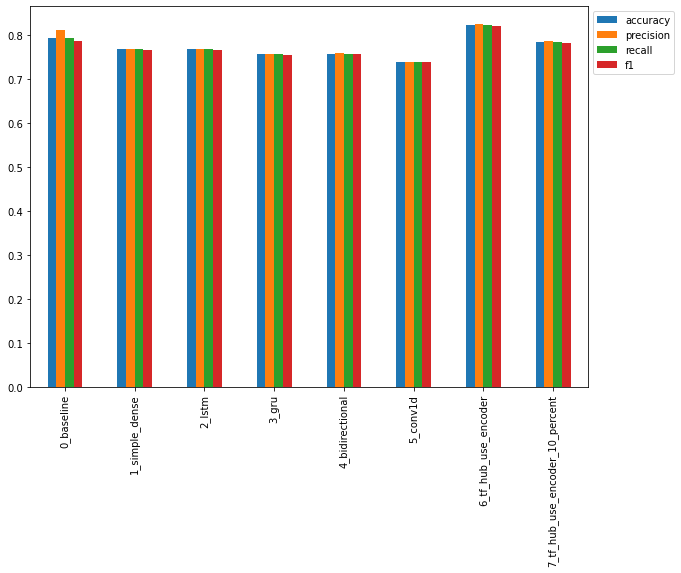

In [108]:
#plot and compare all the results

all_model_results.plot(kind = 'bar', figsize = (10, 7)).legend(bbox_to_anchor = (1.0,1.0))

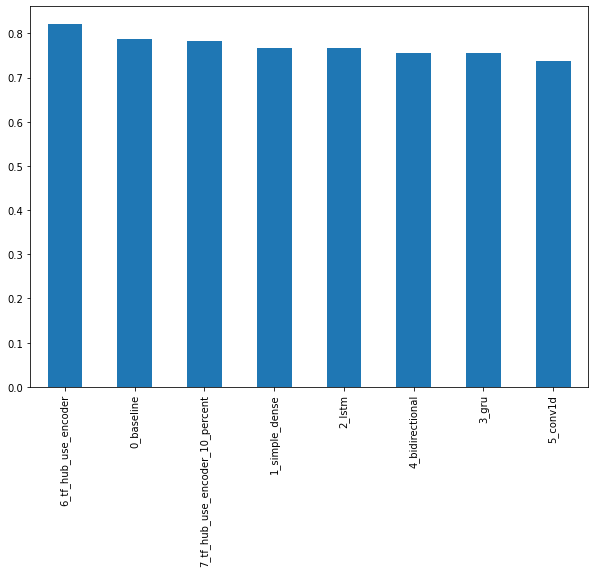

In [109]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending = False)["f1"].plot(kind = 'bar',  figsize = (10,7))